# Generating composite IMFs for Optimal sampling

This file serves to show how one can determine the functional form of a **composite IMF**, i.e. an IMF that consists of the IMFs of several star clusters, so-called **stellar IMFs**, under the assumption that the stellar IMFs are **optimally sampled**. 
The following algorithm is able to determine the value of the composite IMF $\xi_{\mathrm{cIMF}}(m)$ for a grid of masses.

## Why and when is it useful:

Determining the form of a composite IMF can be useful for the investigation of star-formation on smaller scales.\
The code can be used for the fast computation of the cIMF form of custom star cluster samples.\
It is written such that its results can be used in combination with the [galIMF](https://github.com/Azeret/galIMF) module, which uses a mass-grid to determine the IGIMF form. With the same mass grid, clusters could be added or subtracted from the IGIMF, when e.g sub-galactic regions are aimed to investigate.

It is especially useful for the investigation of the high-mass end behavior $(m>1\,M_{\odot})$ of cIMFs for different cluster populations. For example it can be helpful to determine, under which circumstances the local cIMF within a starburst region may become top-heavy, i.e. for what kinds of star cluster populations.\
This code makes it possible to investigate the behaviour of the cIMF for a given star cluster sample without the need to draw large IMF samples that you also need to store somewhere. If you are only interested in the functional form of the cIMF, this is a good opportunity to save time and storage.

## How does it work:

The composite IMF is given as a sum of stellar IMFs:

#### $$\xi_{\mathrm{cIMF}}(m)=\sum_{i=1}^{N} k_i\xi_i(m)$$

For each stellar IMF, its form is correlated with the mass of its cluster such that

$M_{\mathrm{ecl,i}} = \int_{m_{\mathrm{min}}}^{m_{\mathrm{max}}(M_{\mathrm{ecl,i}})} k_i\xi_i(m)\times m \, \mathrm{d}m$, where the upper integration bound $m_{\mathrm{max}}(M_{\mathrm{ecl,i}})$ depends on the cluster mass $M_{\mathrm{ecl,i}}$ and has to be calculated numerically via root-solving. This can be used to determine the normalization constant of the cluster's IMF, via

#### $$k_i = \frac{M_{\mathrm{ecl,i}}}{\int_{m_{\mathrm{min}}}^{m_{\mathrm{max}}(M_{\mathrm{ecl,i}})} \xi_i(m)\times m \, \mathrm{d}m}$$

In this way, one constructs a composite IMF function dependent on the stellar mass $m$, that takes the masses of the embedded clusters as input.

#### $$\xi_{\mathrm{cIMF}}(m)=\sum_{i=1}^{N} k_i\xi_i(m) = \sum_{i=1}^{N} \frac{M_{\mathrm{ecl,i}}}{\int_{m_{\mathrm{min}}}^{m_{\mathrm{max}}(M_{\mathrm{ecl,i}})} \xi_i(m)\times m \, \mathrm{d}m} \xi_i(m) $$

## The Algorithm

### First, three functions from the galIMF module are taken, with which several IMF forms can be described.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy.integrate import quad
from scipy.optimize import root_scalar

In [2]:
def function_alpha_1_change(alpha1_model, M_over_H):
    alpha_1 = 1.3
    if (alpha1_model == 0):
        return alpha_1
    elif (alpha1_model == 1):
        alpha_1_change = alpha_1 + 0.5 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'IGIMF2.5'):
        alpha_1_change = alpha_1 + 0.12 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'Z_MW'):
        alpha_1_change = alpha_1 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        return alpha_1_change
    elif (alpha1_model == 'Z'):
        alpha_1_change = alpha_1 + 63 * (10**M_over_H - 1) * 0.0142
        return alpha_1_change
    else:
        print('Invalid Input for alpha1 model')
        return

## Function to change alpha_2 depending on the model; imported from galimf.py
def function_alpha_2_change(alpha2_model, M_over_H):
    alpha_2=2.3
    if (alpha2_model == 0):
        return alpha_2
    elif (alpha2_model == 1):
        alpha_2_change = alpha_2 + 0.5 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'Z_MW'):
        alpha_2_change = alpha_2 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'Z'):
        alpha_2_change = alpha_2 + 63 * (10**M_over_H - 1) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'IGIMF2.5'):
        alpha_2_change = alpha_2 + 0.12 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'R14'):
        alpha_2_change = 2.3 + 0.0572 * M_over_H
        return alpha_2_change
    else:
        print('Invalid input for alpha2 model')
        return

def function_alpha_3_change(alpha3_model, M_ecl, M_over_H):
    ## M_ecl is the mass of the cluster
    ## M_over_H is the metallicity of the cluster in [Z]
    ## alpha3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
    if (alpha3_model == 0):
        default_alpha3 = 2.3
        # print("alpha_3 is set to be a constant: %s, as this is the default alpha_3 value for alpha3_model 0.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (default_alpha3))
        return default_alpha3
    elif (alpha3_model == 1):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        if rho < 9.5 * 10 ** 4:
            alpha_3_change = 2.3
        else:
            alpha_3_change = 1.86 - 0.43 * math.log(rho / 10 ** 6, 10)
        # print("Notification in file 'alpha3_model' uncompleted")
        if alpha_3_change < 0.5:
            print("IMF alpha_3 being", alpha_3_change, "out of the tested range from Marks et al. 2012.")
        return alpha_3_change
    elif (alpha3_model == 2):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        x = -0.14 * M_over_H + 0.99 * math.log(rho / 10 ** 6, 10)
        if x < -0.87:
            alpha_3_change = 2.3
        else:
            alpha_3_change = -0.41 * x + 1.94
        # print("Notification in file 'alpha3_model' uncompleted")
        return alpha_3_change
    elif (alpha3_model == 'R14'):
        alpha_3_change = 2.3 + 0.0572 * M_over_H
        return alpha_3_change
    else:
        # print("alpha_3 is set to be a constant: %s, as this is the input value of parameter 'alpha3_model'.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (alpha3_model))
        return alpha3_model

### Then, a function to numerically determine the value of $m_{\mathrm{max}}$ is defined, considering the stellar IMF is optimally sampled. 

#### This function uses the information in the supplementary document of the galIMF module to find the value of $m_{\mathrm{max}}$ via root-solving.

In [3]:
## Find m_max for a given M_ecl; m_max is the upper integration limit for the most massive star in the cluster
## m_max is NOT the mass of the most massive star in the cluster!

## Make finding m_max into a function
## M_ecl is the mass of the cluster 
## alpha_3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
## M_over_H is the metallicity of the cluster

### This function serves to find the most massive stellar mass of an optimally sampled IMF
### dependent on the cluster mass and metallicity

def find_m_max_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.0  # IMF power-index breaking mass [solar mass]

    I = 1.0 ## I=I_str

    alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
    alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
    alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H)  # IMF power-index for M_turn2 < M < M_str_U

    def Max(M_max):
        eq1 = M_ecl * M_str_U**(1-alpha_3) / (I * (1-alpha_3)) - M_turn2**(alpha_2-alpha_3) * M_turn**(alpha_1-alpha_2) / (2-alpha_1) * (M_turn**(2-alpha_1) - M_str_L**(2-alpha_1)) - M_turn2**(alpha_2-alpha_3) / (2-alpha_2) * (M_turn2**(2-alpha_2) - M_turn**(2-alpha_2)) + M_turn2**(2-alpha_3) / (2-alpha_3)
        eq2 = M_max**(2-alpha_3) / (2-alpha_3) + M_ecl * M_max**(1-alpha_3) / (I * (1-alpha_3))
        return eq1 - eq2
    
    sol = root_scalar(Max, bracket=[M_str_L, 0.9999*M_str_U])
    M_max = sol.root

    return M_max

## And using those functions, the normalization constant of each IMF can be determined directly from its cluster mass $M_{\mathrm{ecl}}$, while considering the form of the IMF

In [4]:
#### This function serves to calculate the normalization constant by calculating an optimally sampled IMF

def normalization_constant_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity):
    
    ## first define a varying IMF function

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=find_m_max_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)


    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

    def IMF_m(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return x**(1-alpha_1)
        if m_1<=x<m_2:
            return x**(1-alpha_2)*m_1**(alpha_2-alpha_1)
        if m_2<=x<=m_max:
            return x**(1-alpha_3)*m_1**(alpha_2-alpha_1)
        if x>m_max:
            return 0
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]

    return normalization_constant, m_max

## And finally, the value of cIMF (or IGIMF) at each stellar mass can be determined by adding up the IMFs of each embedded cluster

This function takes in the masses of the clusters and a grid of stellar masses. It determines the values of the IMFs for each stellar mass and returns an array of the values of the composite IMF for the points on the mass grid.

In [5]:
## Define the cIMF/IGIMF function as a sum of IMFs
## This function returns the cIMF/IGIMF, for optimally sampled stellar IMFs

def cIMF_optimal_sampling(M_ecl_array, m_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity):

    ### define the IMF such that one can give a mass grid m as input
    ### The function then returns an array with the xi(m) values
    def IMF_func(m, M_ecl, k1, M_max):
        M_turn = 0.5
        M_turn2 = 1.0
        m_0 = 0.08
        m_1 = 0.5
        m_2 = 1.0
    
        alpha_1 = function_alpha_1_change(alpha_1_model, Metallicity)
        alpha_2 = function_alpha_2_change(alpha_2_model, Metallicity)
        alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)
    
        m_max = M_max
        k_1 = k1
        k_2 = k_3 = k_1 * m_1**(alpha_2 - alpha_1)
    
        # m ist ein Array
        result = np.zeros_like(m, dtype=float)
    
        mask_0 = (m < m_0)
        mask_1 = (m_0 <= m) & (m < m_1)
        mask_2 = (m_1 <= m) & (m < m_2)
        mask_3 = (m_2 <= m) & (m <= m_max)
        mask_4 = (m > m_max)
    
        result[mask_1] = k_1 * m[mask_1]**(-alpha_1)
        result[mask_2] = k_2 * m[mask_2]**(-alpha_2)
        result[mask_3] = k_3 * m[mask_3]**(-alpha_3)
        # mask_0 und mask_4 bleiben 0
    
        return result

    cIMF_array=np.zeros(len(m_array))
    i=0
    ## For each cluster determine the normalization and m_max and add their IMFs to the cIMF array
    while i<len(M_ecl_array):
        k, M_max =normalization_constant_optimal(M_ecl_array[i], alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)
        cIMF_array=cIMF_array + IMF_func(m_array, M_ecl_array[i], k, M_max)
        i=i+1
       
    return cIMF_array

# Examples

Now, it is demonstrated how the function can be used on a few examples

## Small samples

First, it it possible to define a small array of cluster masses and the function will then draw the corresponding composite IMF values $\xi_{\mathrm{cIMF}}(m)=\sum_{i=1}^{N}\xi_i(m)$ for each point $m$ on the mass grid, using the specified IMF form.

Text(0, 0.5, '$\\xi_{\\mathrm{cIMF}}(m)$')

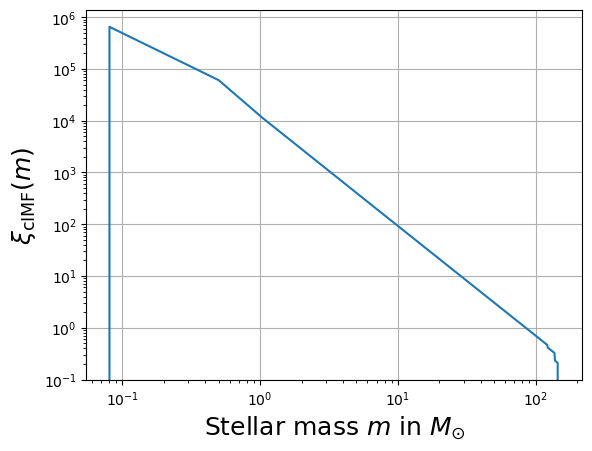

In [6]:
## Use a varying IMF after Yan et al. 2021
alpha_1_model='Z'
alpha_2_model='Z'
alpha_3_model=2
Metallicity= 0 ## in [Z]

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array=np.array([100,200,500,1e4,2e4,4e4])
cIMF_array_optimal=cIMF_optimal_sampling(M_ecl_array, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)
plt.loglog(m_input_array,cIMF_array_optimal)
plt.grid()
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'$\xi_{\mathrm{cIMF}}(m)$', size=18)

The ripples you see at the high-mass end are due to the stellar IMFs having a maximum stellar mass defined by their cluster mass. This means you see the stellar IMFs being stacked on top of each other.

## Larger samples

You can draw embedded cluster masses e.g. from using the code in *ECMF_sampling.ipynb* and visualize the cIMF form here. You can then visualize the cIMF here if your cluster sample is rather large and the IMF sampling might therefore take some time (and storage).

In [7]:
## Choose again varying IMF
alpha_1_model='Z'
alpha_2_model='Z'
alpha_3_model=2
Metallicity= 0 ## in [Z]


m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array2=np.loadtxt('Test_Clusters_Mtot_4e6_beta_2_PL.txt')
## Cut off the sample after 10000 clusters
M_ecl_array2=M_ecl_array2[:10000]


t0 = time.time()

cIMF_array_optimal2=cIMF_optimal_sampling(M_ecl_array2, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)

t1 = time.time()

total = t1-t0
print('For a sample of 10000 clusters, the code determines a mass grid of 1000 points in',total,'seconds')

For a sample of 10000 clusters, the code determines a mass grid of 1000 points in 2.3799381256103516 seconds


Text(0, 0.5, '$\\xi_{\\mathrm{cIMF}}(m)$')

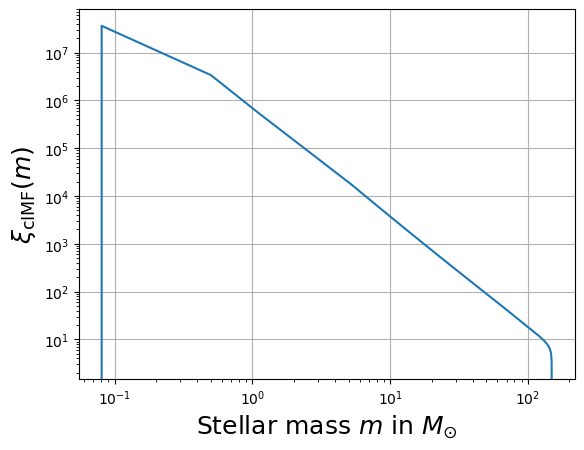

In [8]:
plt.loglog(m_input_array,cIMF_array_optimal2)
plt.grid()
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'$\xi_{\mathrm{cIMF}}(m)$', size=18)

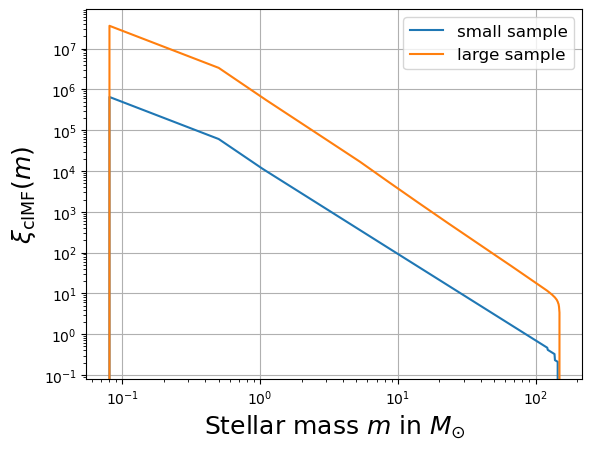

In [9]:
plt.loglog(m_input_array,cIMF_array_optimal, label='small sample')
plt.loglog(m_input_array,cIMF_array_optimal2, label='large sample')
plt.grid()
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'$\xi_{\mathrm{cIMF}}(m)$', size=18)
plt.legend(fontsize=12)

# Comparison of IMF slopes

Text(0, 0.5, '$\\xi_{\\mathrm{cIMF}}(m)$')

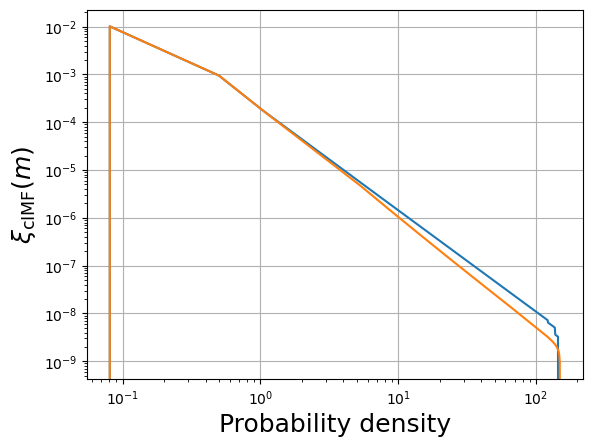

In [10]:
plt.loglog(m_input_array,cIMF_array_optimal/np.sum(cIMF_array_optimal), label='small sample')
plt.loglog(m_input_array,cIMF_array_optimal2/np.sum(cIMF_array_optimal2), label='large sample')
plt.grid()
plt.xlabel(r'Probability density', size=18)
plt.ylabel(r'$\xi_{\mathrm{cIMF}}(m)$', size=18)

#### It is evident that the smaller sample has a top-heavier IMF, but what is the slope exactly?
#### To try and assess this, one can perform a fit on the drawn cIMFs using *curve_fit*:

In [11]:
from scipy.optimize import curve_fit

def powerlaw(x, a, b):
    return a*x+b

[-2.12383182  4.09043957]
[5.10399958e-05 5.67245744e-05]
[-2.30725495  5.87085199]
[0.00136714 0.00171595]


/tmp/ipykernel_4723/367447760.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(m_input_array), np.log10(cIMF_array_optimal), label=r'small sample')
/tmp/ipykernel_4723/367447760.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(m_input_array), np.log10(cIMF_array_optimal2), label=r'large sample')


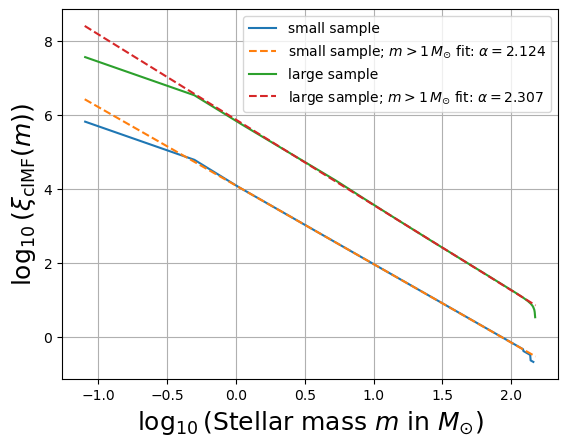

In [12]:
## Evaluate the slope for m > 1 solar mass
cIMF_array_optimal_cut=cIMF_array_optimal[cIMF_array_optimal>1]
m_input_array_cut=m_input_array[cIMF_array_optimal>1]

plt.plot(np.log10(m_input_array), np.log10(cIMF_array_optimal), label=r'small sample')

popt, pcov = curve_fit(powerlaw, np.log10(m_input_array_cut[m_input_array_cut>1]), np.log10(cIMF_array_optimal_cut[m_input_array_cut>1]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), powerlaw(np.log10(m_input_array), *popt), label=r'small sample; $m>1\,M_{\odot}$ fit: $\alpha= %5.3f$' %-popt[0], linestyle='--')

cIMF_array_optimal2_cut=cIMF_array_optimal2[cIMF_array_optimal2>1]
m_input_array_cut=m_input_array[cIMF_array_optimal2>1]

plt.plot(np.log10(m_input_array), np.log10(cIMF_array_optimal2), label=r'large sample')

popt, pcov = curve_fit(powerlaw, np.log10(m_input_array_cut[m_input_array_cut>1]), np.log10(cIMF_array_optimal2_cut[m_input_array_cut>1]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), powerlaw(np.log10(m_input_array), *popt), label=r'large sample; $m>1\,M_{\odot}$ fit: $\alpha= %5.3f$' %-popt[0], linestyle='--')

plt.grid()
plt.xlabel(r'$\log_{10}$(Stellar mass $m$ in $M_{\odot})$', size=18)
plt.ylabel(r'$\log_{10}(\xi_{\mathrm{cIMF}}(m))$', size=18)
plt.legend()

#### In this way, the cIMF slopes can be estimated in a simple manner. The small sample has a top-heavy IMF slope of $\alpha\approx 2.12$, while the larger sample seems to follow the canonical value of $\alpha=2.3$.

## Final notes

The running time of the code scales with the number of star clusters. So for **very** large cluster samples (>1.000.000), I suggest to rather use the [galIMF](https://github.com/Azeret/galIMF) code to directly sample a custom composite IMF from it, as it is more optimized than this work.\
Also, a larger number of points on the mass grid than necessary will additionally lengthen the runtime, so it is advised to start with a smaller number of grid points first.

Further, if you only aim to investigate the high-mass end, my advice is to cut your sample first such that only the clusters that produce large enough stellar masses are included for the computation of the cIMF and you only use mass grid points within the mass range relevant for your work. This should help to shorten the computing time.